In [2]:
#%% Mount Google drive if you use colab for save and load LSTM models
if 'google.colab' in str(get_ipython()):
  colab = 1
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')

  # Set your path on the google drive here for save and download files
  path = '/content/drive/MyDrive/Transformer_MPC/02_Surrogate/FOPDT/SISO/'
    
else:
  colab = 0
  print('Not running on Colab')
  path = ''

# Install(if it hasn't been) and Import GEKKO package
try:
    from gekko import GEKKO
except:
    !pip install gekko
    # restart kernel if this doesn't import
    from gekko import GEKKO

Running on Colab
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
     |████████████████████████████████| 12.4 MB 4.1 MB/s 


## 1. FOPDT Simulation for Generating training Data

In [3]:
# from gekko import GEKKO
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from plotly.subplots import make_subplots
import plotly.graph_objects as go

from pickle import dump

# from smt.sampling_methods import LHS
# from smt.sampling_methods import Random

In [4]:
tfinal = 30 # fianl time

In [5]:
m=GEKKO(remote=False)
m.time = np.linspace(0,tfinal-1,tfinal)

In [6]:
K = m.FV(1) # Process Gain
tau = m.FV(2) # Time Constant

In [7]:
u_input = np.zeros(tfinal)
u_input[5:] = 1

In [8]:
y = m.CV()
u = m.MV(u_input)
m.Equation(tau*y.dt()+y==K*u) #FOPDT Equation

m.options.IMODE=4

In [9]:
m.solve(disp=False)

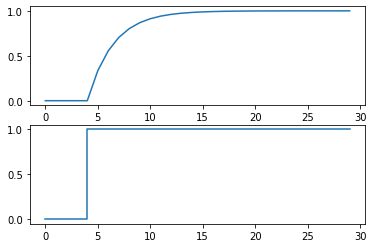

In [10]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, y)
plt.subplot(2,1,2)
plt.plot(m.time, u, drawstyle='steps')
plt.show()

## 2. Generating input signal (Full Random and LHS)

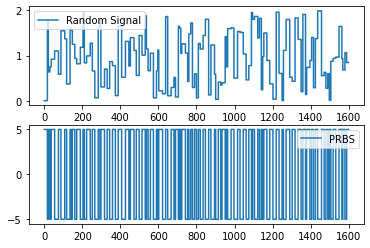

In [11]:
import numpy as np
import matplotlib.pyplot as plt

nstep = 1600 # Choose training data length

# random signal generation

a_range = [0,2]
a = np.random.rand(nstep) * (a_range[1]-a_range[0]) + a_range[0] # range for amplitude
a[0] = 0

b_range = [5, 20]
b = np.random.rand(nstep) *(b_range[1]-b_range[0]) + b_range[0] # range for frequency
b = np.round(b)
b = b.astype(int)

b[0] = 0

for i in range(1,np.size(b)):
    b[i] = b[i-1]+b[i]

# Random Signal
i=0
random_signal = np.zeros(nstep)
while b[i]<np.size(random_signal):
    k = b[i]
    random_signal[k:] = a[i]
    i=i+1

# PRBS
a = np.zeros(nstep)
j = 0
while j < nstep:
    a[j] = 5
    a[j+1] = -5
    j = j+2

i=0
prbs = np.zeros(nstep)
while b[i]<np.size(prbs):
    k = b[i]
    prbs[k:] = a[i]
    i=i+1

plt.figure(0) 
plt.subplot(2,1,1)
plt.plot(random_signal, drawstyle='steps',label='Random Signal')
plt.legend()
plt.subplot(2,1,2)
plt.plot(prbs, drawstyle='steps', label='PRBS')
plt.legend()
plt.show()

## 3. Evaluate the Random Input Signal

In [12]:
tfinal = nstep
m.time = np.linspace(0,tfinal-1,tfinal)
u.value = random_signal

In [13]:
m.options.IMODE = 4
m.solve(disp=False)

In [14]:
data = pd.DataFrame(
        {"u": u,
         "y": y},
        index = np.linspace(1,nstep,nstep,dtype=int))

In [15]:
data.to_pickle(path + 'open_loop_data_SISO.pkl')

In [ ]:
# unpickled = pd.read_pickle('/content/drive/MyDrive/Transformer_MPC/FOPDT/open_loop_data_SISO.pkl')

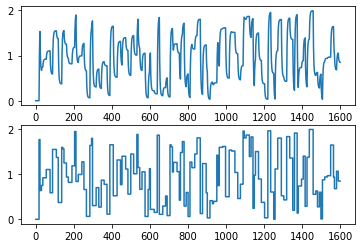

In [16]:
plt.figure(0)
plt.subplot(2,1,1)
plt.plot(m.time, data["y"])
plt.subplot(2,1,2)
plt.plot(m.time, data["u"], drawstyle='steps')
plt.show()